In [32]:
from tensorflow.keras.layers import Reshape, Flatten, Input, Dense
# For dataset
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
# For miscellaneous functions
from tensorflow.keras import utils
from tensorflow.keras.models import Model, Sequential
# For array functions
import numpy as np
import tensorflow as tf
# For plotting
import matplotlib.pyplot as plt
# For confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

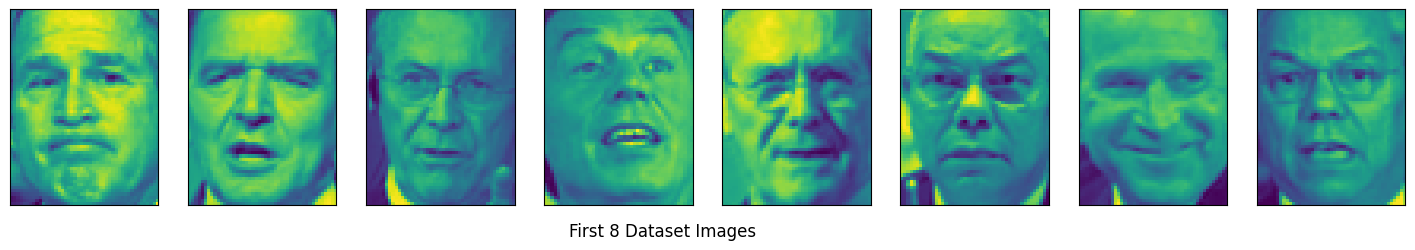

STATISTICS
Dataset has  1140 sample images
Each image is  62 x 47
Faces are of:
 ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


In [2]:
# Read the data
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.5)
# Get statistics of data
n_samples, r, c = lfw_people.images.shape
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Display first 8 images of dataset
total_cols = 8
fig, ax = plt.subplots(nrows=1, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

for j in range(total_cols):
    ax[j].imshow(lfw_people.images[j, :, :])
plt.title('First 8 Dataset Images', y=-0.2, x=-4)
plt.show()

# Print statistics
print('STATISTICS')
print('Dataset has ', n_samples, 'sample images')
print('Each image is ', r, 'x', c)
print('Faces are of:\n', target_names)

In [3]:
X = lfw_people.images
y = lfw_people.target
# Create train and test sets
train_X, test_X, train_Y, test_Y = train_test_split(
                        X, y, test_size=0.25, random_state=0)
# Normalize each image
train_X = train_X/255
test_X = test_X/255
# Create 5 dimensional binary indicator vectors
train_Y_categorical = utils.to_categorical(train_Y)
test_Y_categorical = utils.to_categorical(test_Y)
# Print statistics
print("Training data shape: ", train_X.shape)
print("Training categorical labels shape: ", train_Y_categorical.shape)
print("Test data shape: ", test_X.shape)
print("Test categorical labels shape: ", test_Y_categorical.shape)


Training data shape:  (855, 62, 47)
Training categorical labels shape:  (855, 5)
Test data shape:  (285, 62, 47)
Test categorical labels shape:  (285, 5)


In [12]:
latent_dimension = 420
input_shape = (train_X.shape[1], train_X.shape[2])
n_inputs = input_shape[0]*input_shape[1]
images = Input(shape=(input_shape[0], input_shape[1], ))
vector_images = Flatten()(images)
# encoder
encoder_hidden = Dense(int(n_inputs/2), activation='relu')(vector_images)
latent = Dense(latent_dimension, activation='relu')(encoder_hidden)
# define decoder
decoder_hidden = Dense((int)(n_inputs/2), activation='relu')(latent)
# output dense layer
decoder_output = Dense(n_inputs, activation='linear')(decoder_hidden)
output_images = Reshape((input_shape[0], input_shape[1], ))(decoder_output)
# define autoencoder model
autoencoder = Model(inputs=images, outputs=output_images)
# compile autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 62, 47)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2914)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1457)                │       4,247,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 420)                 │         612,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1457)                │         613,397 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2914)                │       4,248,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 62, 47)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,721,524 (37.08 MB)

 Trainable params: 9,721,524 (37.08 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# fit the autoencoder model to reconstruct input
history = autoencoder.fit(train_X, train_X, epochs=50, validation_split=0.33, verbose=0)

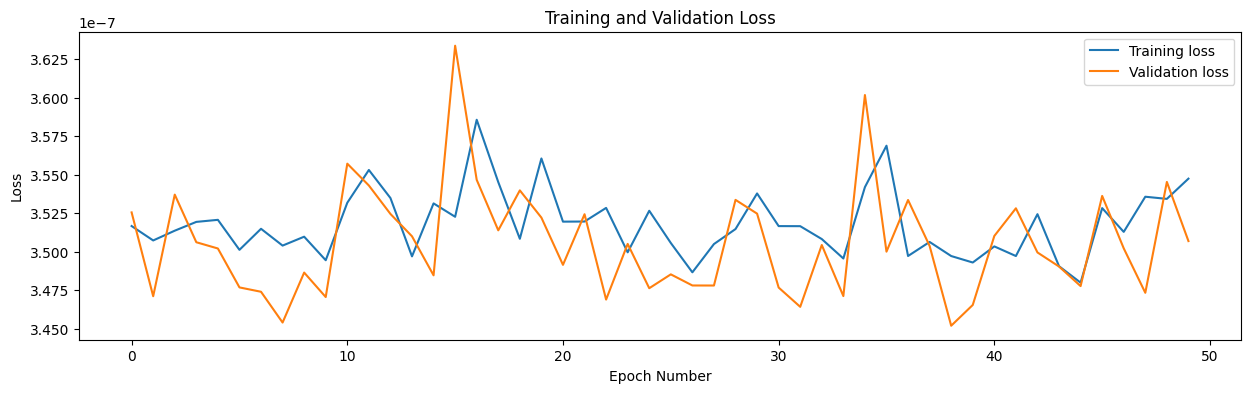

In [40]:
fig = plt.figure(figsize=(15,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


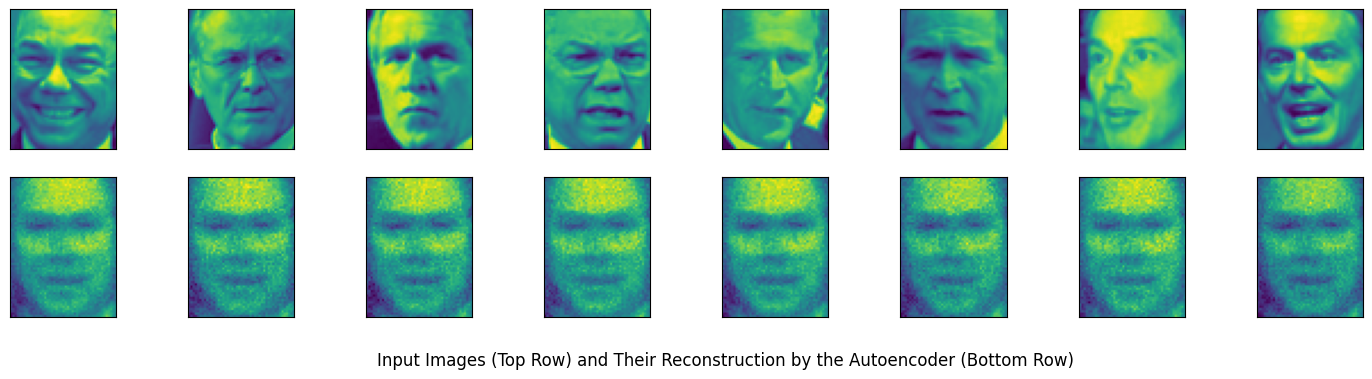

In [41]:
# Reconstruction
reconstructed_test = autoencoder.predict(test_X)
# Display the inputs and reconstructions
total_cols = 8
fig, ax = plt.subplots(nrows=2, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

for j in range(total_cols):
    ax[0, j].imshow(test_X[j, :, :])
    ax[1, j].imshow(reconstructed_test[j, :, :])
plt.title('Input Images (Top Row) and Their Reconstruction by the Autoencoder (Bottom Row)', y=-0.4, x=-5)
plt.show()

In [42]:
# Encoder model
encoder_model = Model(inputs=images, outputs=latent)
encoder_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 62, 47)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2914)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1457)                │       4,247,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 420)                 │         612,360 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,859,515 (18.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,859,515 (18.54 MB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


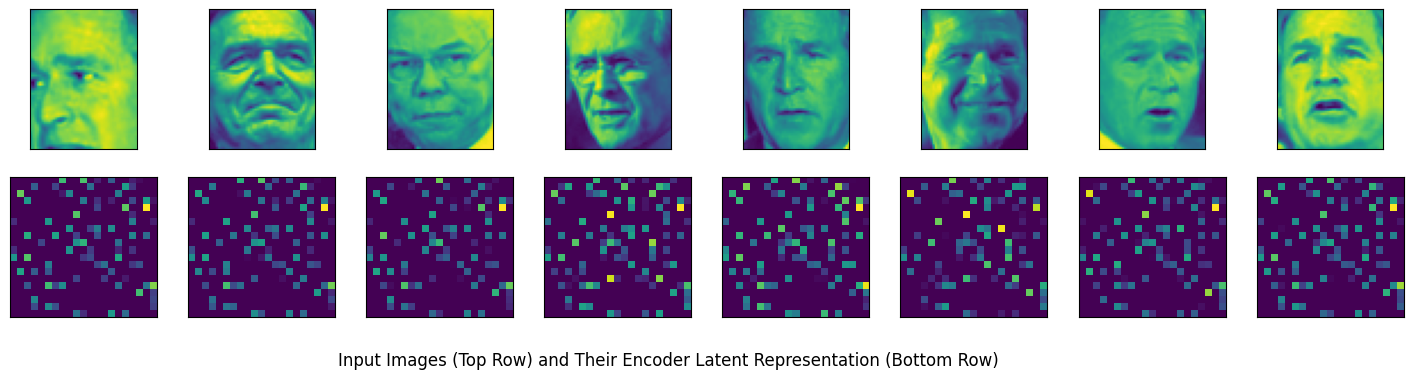

In [43]:
# Encoder output
encoder_output = encoder_model.predict(train_X)

latent_dim = encoder_output.shape[1]
latent_shape = (20,21)
# Plot the first 8 images and their corresponding latent representation
total_cols = 8
fig, ax = plt.subplots(nrows=2, ncols=total_cols,
                      figsize=(18,4),
                      subplot_kw=dict(xticks=[], yticks=[]))

for j in range(total_cols):
    train_image = train_X[j, :, :]
    ax[0, j].imshow(train_image)
    encoder_image = np.reshape(encoder_output[j, :], latent_shape)
    ax[1, j].imshow(encoder_image)
plt.title('Input Images (Top Row) and Their Encoder Latent Representation (Bottom Row)', y=-0.4, x=-4)
plt.show()

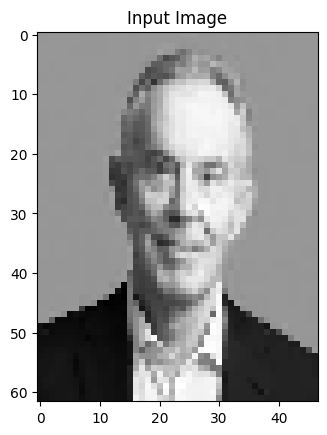

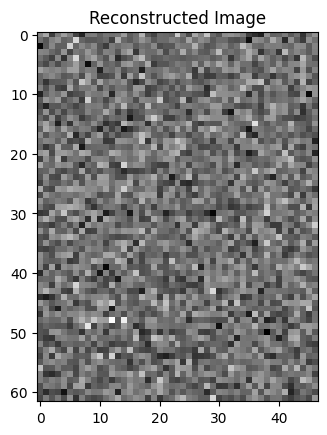

In [44]:
# User input image processing (assuming user provides grayscale image)
def predict_image(user_image):
  """Predicts the reconstruction of a user-provided grayscale image.

  Args:
    user_image: The grayscale image to predict.

  Returns:
    The reconstructed image.
  """
  # Preprocess the user image (resize, normalize)
  # Check if the image has non-zero dimensions before reshaping
  if user_image.shape[0] == 0 or user_image.shape[1] == 0:
    raise ValueError("Input image has zero dimensions, which is invalid.")

  # Resize the image to the expected input shape of the autoencoder
  user_image = tf.image.resize(user_image, [62, 47])  # Resize to (62, 47)

  # The input image is already in the correct shape (1, height, width, 1)
  # No need to reshape here as it is already reshaped before calling the function
  #user_image = user_image.reshape((1, user_image.shape[0], user_image.shape[1], 1))  # Add channel dimension for grayscale
  user_image = user_image / 255.0  # Normalize

  # Predict the reconstruction
  # Use predict_on_batch to handle variable batch sizes
  reconstructed_image = autoencoder.predict_on_batch(user_image)

  return reconstructed_image

# ... (rest of the code remains the same)

# Example usage
user_image = plt.imread("./thumb.jpeg")  # Replace with your image path
# Handle grayscale/color conversion if necessary
grayscale_image = user_image[:, :, 0]  # Assuming grayscale image

# Check if the grayscale image has non-zero dimensions before prediction
if grayscale_image.shape[0] == 0 or grayscale_image.shape[1] == 0:
  raise ValueError("Grayscale image has zero dimensions, which is invalid.")

# Reshape to (1, height, width, 1) for prediction and resize
grayscale_image = grayscale_image.reshape((1, grayscale_image.shape[0], grayscale_image.shape[1], 1))
grayscale_image = tf.image.resize(grayscale_image, [62, 47]) # Resize to (62, 47)

reconstructed_image = predict_image(grayscale_image)

# Display the user image and its reconstruction
plt.imshow(grayscale_image[0, :, :, 0], cmap='gray') # Access the image correctly for display
plt.title("Input Image")
plt.show()

# Reshape to (height, width) for display
reconstructed_image = reconstructed_image.reshape(reconstructed_image.shape[1], reconstructed_image.shape[2])

plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.show()